# Лабораторна робота 3: Знайомство з нейромережами

## 1. Повнозв'язані нейронні мережі

Задача класифікації береться із першої лабораторної:

Той самий [датасет](https://archive.ics.uci.edu/dataset/763/land+mines-1) з показниками детектора мін для різних типів грунту, та різних типів наземних мін із лабораторної 1.

![table1](extras\table1.png "table2")

До характеристики грунту було застосовано "One-Hot" кодування.

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler


data = pd.read_csv("data\mine_data_norm.csv")

# Separate into separate Wet/Dry and Soil type
data['SH'] = (data.loc[:, 'S'] > 0.5).astype(float)
data['ST'] = (data.loc[:, 'S'] * 10) % 6

# One-Hot-Encoding of Soil types
enc_s = OneHotEncoder()
data[['Sandy', 'Humus', 'Limy']] = enc_s.fit_transform(data[['ST']]).toarray()

# Table cleaning
DF = data.drop(['ST', 'S'], axis=1)
DF = DF.drop(['M'], axis=1).join(DF['M'])
DF = DF.rename(columns={'V': 'Voltage', 'H': 'Height', 'SH': 'Humidity', 'M': 'Mine'})
DF['Mine'] = DF['Mine'] - 1

DF.head()

,Voltage,Height,Humidity,Sandy,Humus,Limy,Mine
0,0.338157,0.000000,0.0,1.0,0.0,0.0,0
1,0.320241,0.181818,0.0,1.0,0.0,0.0,0
2,0.287009,0.272727,0.0,1.0,0.0,0.0,0
3,0.256284,0.454545,0.0,1.0,0.0,0.0,0
4,0.262840,0.545455,0.0,1.0,0.0,0.0,0


Розіб'ємо дані на два піднабори — тренувальний та тестовий:

In [2]:
from sklearn.model_selection import train_test_split
from collections import Counter

X = DF.drop(['Mine'], axis=1)
Y = DF['Mine']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.35)
Counter(Y_train)

Counter({2: 48, 1: 47, 3: 44, 0: 41, 4: 39})

### Будуємо модель

На вхід — 6 нейронів (вектор із 6 значень)


На вихід — 5 нейронів (5 можливих класів)



2 проміжних шари по 300 нейронів з функцією активації ReLU

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = keras.Sequential(
    [
        keras.layers.Input(shape=(6, )),
        keras.layers.Dense(75, activation="relu"),
        keras.layers.BatchNormalization(trainable=False),
        keras.layers.Dense(150, activation="relu"),
        keras.layers.BatchNormalization(trainable=False),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(150, activation="relu"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(150, activation="relu"),
        keras.layers.BatchNormalization(trainable=False),
        keras.layers.Dense(75, activation="relu"),
        keras.layers.BatchNormalization(trainable=False),
        keras.layers.Dense(5, activation="softmax"),
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 75)             │           525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75)             │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150)            │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 150)            │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75)             │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           380 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,730 (276.29 KB)

 Trainable params: 68,930 (269.26 KB)

 Non-trainable params: 1,800 (7.03 KB)

In [4]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [5]:
history = model.fit(X_train,
                    Y_train,
                    epochs=75,
                    batch_size=110,                                   
                    validation_data=(X_test, Y_test))

Epoch 1/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.1550 - loss: 1.6114 - val_accuracy: 0.1765 - val_loss: 1.6092
Epoch 2/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2310 - loss: 1.6026 - val_accuracy: 0.2437 - val_loss: 1.6081
Epoch 3/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2219 - loss: 1.6000 - val_accuracy: 0.2521 - val_loss: 1.6080
Epoch 4/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2584 - loss: 1.5914 - val_accuracy: 0.2605 - val_loss: 1.6062
Epoch 5/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2827 - loss: 1.5853 - val_accuracy: 0.2521 - val_loss: 1.6033
Epoch 6/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2766 - loss: 1.5774 - val_accuracy: 0.2605 - val_loss: 1.5983
Epoch 7/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2888 - loss: 1.5731 - val_accuracy: 0.2437 - val_loss: 1.5889
Epoch 8/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2918 - loss: 1.5535 - val_accuracy: 0.2521 - val_loss: 1.5710

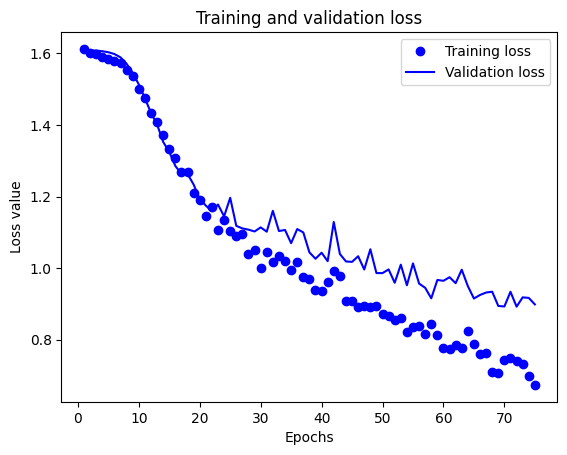

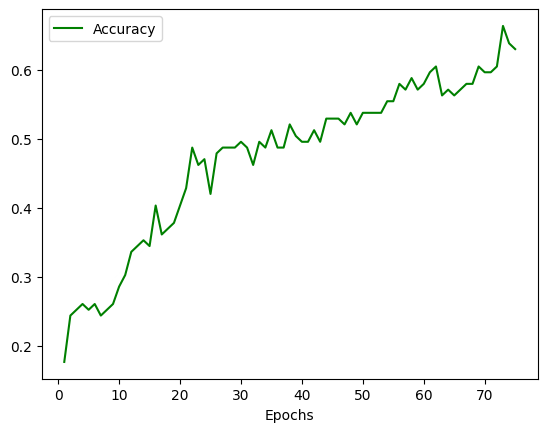

In [6]:
import matplotlib.pyplot as plt

history_dict = history.history

epochs = range(1, len(history_dict["loss"]) + 1)
plt.plot(epochs, history_dict["loss"], "bo", label="Training loss")
plt.plot(epochs, history_dict["val_loss"], "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.legend()
plt.show()

plt.plot(epochs, history_dict["val_accuracy"], "g", label="Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Не дуже великий датасет :(

Але результат все одно непоганий, краще більшості методів із першої лабораторної

In [7]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Inference accuracy:', score[1])

Inference accuracy: 0.6302521228790283
